In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from libary import *
from recurrent import *
from ARMA import *

In [2]:
# Used data
num_of_features = 2

train_ratio = 0.5
valid_ratio = 0.25

In [3]:
# Import data
Data = pd.read_csv('Data_1min.csv', dtype=str)

# Select frequency
frequencies = ['min','5min','15min','60min','D']
frequencies_number_of_samples = np.multiply([390,78,26,6,1],252)
frequency_index = 4
Data = resample_data(Data,frequencies[frequency_index])

# Create datasets
dates = Data['Date']
Data.drop('Date', inplace=True, axis=1)

Data = Data.astype('float64')
prices = Data

# Log return
Returns = log_return(Data).to_numpy()

# Visualize data
#visualise_data(Data, Returns)

# Create study peridos
number_of_study_periods = np.floor(Returns.shape[0]/frequencies_number_of_samples[frequency_index]).astype(int)-1
study_periods = np.zeros((2,number_of_study_periods, frequencies_number_of_samples[frequency_index]*2))
for i in range(number_of_study_periods):
    study_periods[0,i] = Returns[i*frequencies_number_of_samples[frequency_index]:\
                                    (i+2)*frequencies_number_of_samples[frequency_index]].flatten()
#     plt.plot(study_periods[0,i])
#     plt.show()
    study_periods[1,i] = dates.iloc[i*frequencies_number_of_samples[frequency_index]:\
                                    (i+2)*frequencies_number_of_samples[frequency_index]].to_numpy().flatten()

In [4]:
number_of_random_search = 2
print('LSTM')
LSTM_names, LSTM_results = train_recurrent_model('LSTM',number_of_study_periods,study_periods,number_of_random_search, train_ratio, valid_ratio)
print('GRU')
GRU_names, GRU_results = train_recurrent_model('GRU',number_of_study_periods,study_periods,number_of_random_search, train_ratio, valid_ratio)

print('ARMA')
mse_ARMA, ARMA_parameters = train_ARMA(number_of_study_periods, study_periods, train_ratio, valid_ratio)

LSTM
Period: 0
look_back-11, n_epochs-1000, batch_size-512, optimizer-rmsprop, layers-[12], dropout-0.267 0.00030609792581589066
look_back-27, n_epochs-1000, batch_size-512, optimizer-adam, layers-[20, 18], dropout-0.133 0.00030855336830711315
Period: 1
look_back-2, n_epochs-1000, batch_size-1024, optimizer-rmsprop, layers-[15, 7], dropout-0.0 0.0001277477155665567
look_back-26, n_epochs-1000, batch_size-1024, optimizer-rmsprop, layers-[4, 3], dropout-0.067 0.00013710059671030142
Period: 2
look_back-9, n_epochs-1000, batch_size-1024, optimizer-sgd, layers-[19], dropout-0.133 5.965648608011327e-05
look_back-6, n_epochs-1000, batch_size-1024, optimizer-adam, layers-[2], dropout-0.6 6.419221572847959e-05
Period: 3
look_back-3, n_epochs-1000, batch_size-512, optimizer-sgd, layers-[16], dropout-0.0 6.375345118175635e-05
look_back-32, n_epochs-1000, batch_size-512, optimizer-rmsprop, layers-[9], dropout-0.0 8.404576887531086e-05
Period: 4
look_back-36, n_epochs-1000, batch_size-256, optimize

In [5]:
print(np.concatenate((np.reshape(mse_ARMA, [number_of_study_periods,1]),\
                      np.reshape(LSTM_results[:,2], [number_of_study_periods,1]),\
                      np.reshape(GRU_results[:,2], [number_of_study_periods,1])), axis=1))

[[3.35695265e-04 9.24199611e-05 8.06581435e-05]
 [7.57164581e-05 6.94843806e-05 6.15156172e-05]
 [2.65057019e-04 2.54267220e-04 2.62638236e-04]
 [5.81906228e-05 5.68085219e-05 5.74625485e-05]
 [5.63607698e-05 3.30752520e-05 3.04541526e-05]
 [1.54166948e-04 6.01963403e-05 6.12804575e-05]
 [1.47931164e-04 1.33760890e-04 1.28111382e-04]
 [2.72251392e-05 2.53026922e-05 2.54890384e-05]]


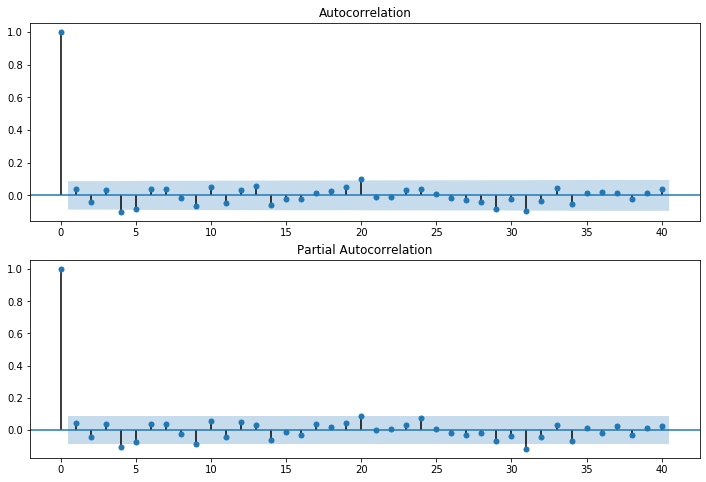

In [6]:
import statsmodels.api as sm
i = 7
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(study_periods[0,i], lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(study_periods[0,i], lags=40, ax=ax2)# , lags=40

In [7]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
 
def predict(coef, history):
	yhat = 0.0
	for i in range(1, len(coef)+1):
		yhat += coef[i-1] * history[-i]
	return yhat
 

X = Returns
size = len(X) - 7
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,1))
	model_fit = model.fit(disp=False)
	ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
	resid = model_fit.resid
	yhat = predict(ar_coef, history) + predict(ma_coef, resid)
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('>predicted=%.3f, expected=%.3f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

>predicted=0.000, expected=0.003
>predicted=-0.000, expected=-0.001
>predicted=-0.000, expected=0.005
>predicted=0.000, expected=0.003
>predicted=-0.000, expected=0.001
>predicted=-0.000, expected=0.000
>predicted=-0.000, expected=0.002
Test RMSE: 0.003
